# Tutorial Overview
The purpose of this tutorial is walking you through the whole process of sentiment analysis by building deep learning models. Sentiment analysis is a binary classifier to determine whether a piece of text is postive or negative, so that the attitude of a author can be derived. Sentiment analysis is widely used in marketing, political election, and public opinion analysis. This toturial will use a Python deep learning library Keras to build models by different approaches, and evaluate performance by several benchmarks.
### Outcome
After reading this tutorial you will know:
- How to prepare and preprocese data to make it available to build deep learning models
- How to use deep learning packages (Keras and Tensorflow) to build models
- How to develop and fit CNN (Convolutional Neural Network) and RNN (Recurrent Neural Network) for sentiment classfication
- How to tune parameters and configration of neural networks to improve correctness
- How to use Tweepy to pull out data from Twitter to evaluate performance by unseen data


### Dataset Description
We will use [IMDB Movie Review](http://ai.stanford.edu/~amaas/data/sentiment/) to train our models. You can learn more and download the dataset through the link. The dataset contains a set of 25,000 highly polar movie reviews. In this tutorial, only the data from training dataset will be used, including 12,500 positive and negative reviews, the data is in pos and neg folders.


### Table of Contents:
- [Installing the libraries](#Installing-Libraries)
- [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
- [Convolutional Neural Network Model](#Convolutional-Neural-Network-Model)
- [LSTM Recurrent Neural Network Model](#LSTM-Recurrent-Neural-Network-Model)
- [Performance Compare with TextBlob and Future Work](#Performance-Compare-with-TextBlob-and-Future-Work)
- [Reference](#Reference)

# Installing Libraries

This tutorial is developed to run under Python 3.7. The packages we need to install are:

- Keras: Keras is a Python deep learning library building on Tensorflow and Theano
- Tweepy: Tweepy make is easier retrive Twitter by Twitter API
- TextBlob: TextBlob is a Python library for NLP tasks such as sentiment analysis, POS etc
- Numpy, Pandas, Matplotlib

All of them can be installed by:

    $ conda install package_name



# Data Loading and Preprocessing

Loading and Cleaning data
Row 5 stores tweet content. Row 0 indicates if the sentiment of this tweet is postive (0 means negative, 1 means positive)

Cleaning rule:
1. remove those rows that either sentiment or content is missing
2. extract sentiment and tweet content row
3. shuffle rows to mix positive and negative tweets

## Data Loading

Download the dataset from Stanford AI website: http://ai.stanford.edu/~amaas/data/sentiment/, unzip and only keep the "train" folder. There shoule be "neg" and "pos" subfolders within. 

We load the dataset by Blob and Pandas. Blob will read all the files with the extension ".txt" into a Python list. Then positive and negative reviews and their corresponding labels are assemble into a Pandas dataframe, and shuffle the dataframe to mix positive and negative reviews. Finally, we calculate the average review length for further vectorizing use.

In [111]:
import numpy as np
import pandas as pd
import glob

In [112]:
# GetReviews will read all files into a Python list, and return the list.
# Each item in the list is a file content
def getReviews(path):
    # read all files with .txt 
    path = path + '*.txt'
    files = glob.glob(path)
    review = []
    for file in files:
        text = open(file).read()
        review.append(text)
    return review

In [113]:
# load positive reviews from train folder
pos_reviews = getReviews('./aclImdb/train/pos/')
# label positive reviews as 1
pos_label = [1] * len(pos_reviews) 
# load negative reviews from train folder
neg_reviews = getReviews('./aclImdb/train/neg/')
# label negatibe reviews as 0
neg_label = [0] * len(pos_reviews) 
df = pd.DataFrame(
    {'Sentiment': pos_label + neg_label,
    'Text': pos_reviews + neg_reviews
    })
df = df.sample(frac=1).reset_index(drop=True) # shuffle
# show the summary of the dataset
df.head()

,Sentiment,Text
0,1,"I don't know what movie some of these other people watched, but they must have seen a different ..."
1,0,"I just couldn't stop laughing!! This movie is incredibly funny and stupid! But, never mind that,..."
2,1,I happened to watch this movie by chance some days ago while flipping channels. My expectations ...
3,0,"Ok, first the good: Cher's performance and the cinematography. Although I'm no Cher fan, she giv..."
4,1,"There is one detail, which is not very common for Jackie Chan movies, but which is present here...."


Tweet length: 
Mean 233.79 words (173.729557)


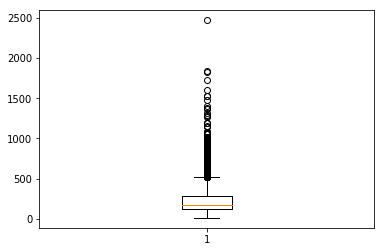

In [114]:
import matplotlib
import matplotlib.pyplot as plt
# average length of tweets
print("Tweet length: ")
result = [len(x.split()) for x in df.Text]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

## Preprocessing 

In this part, we perform text preprocessing on the tweet corpus using NLP techniques.
Keras requires the input format a matrix with shape(a, b), where a is the number of reviews, and b is the sequence length of each review (which is 400 in this case)

The first step is vectorizing the text corpus. We tokenize tweets using keras.preprocessing.text package. After tokenizing, texts are encoded as a sequence of integer value

We only keep the most common 10,000 words after removing all punctuation

In [115]:
from keras.preprocessing.text import Tokenizer
docs = df.Text
max_words = 10000
# create the tokenizer
t = Tokenizer(num_words=max_words)
# fit the tokenizer on the documents
t.fit_on_texts(docs)
# encode documents in the dataset using the fitted tokenizer
encoded_docs = t.texts_to_sequences(docs)
# print(encoded_docs)

Then we pads sequence to make every review has the same length
(400 is the length of one review)

In [131]:
from keras import preprocessing
max_length = 400
# pad or remove values from the start of each sequence
encoded_docs = preprocessing.sequence.pad_sequences(encoded_docs, maxlen=max_length)
print (encoded_docs.shape)
print (encoded_docs)

(25000, 400)
[[   0    0    0 ...,  146   11   17]
 [   0    0    0 ...,   73   50  438]
 [   0    0    0 ...,  287    3  103]
 ..., 
 [   0    0    0 ...,    5   64    9]
 [   0    0    0 ...,  718  155  155]
 [   0    0    0 ...,   20  126 4178]]


## Split dataset
Split the dataset into training (50%) and validation (50%) sets

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_docs, df.Sentiment, test_size=0.5, shuffle=True)

# Convolutional Neural Network Model

In this part, we will used the dataframe we created in the last part to develop a Convolutional Neural Network model. CNN is designed to analyze spatial structure data or imagery data. As we have converted every review to a sequence of words. The sequence of words can be treated as a one-dimensional vector, then CNN can learn to recognize sentence structure as recognizing images.

## Build CNN Model 

In this part, we will walk through every layer of the CNN model we build.

1. The first layer is an Embedding layer, which is the input layer. The basic idea of word embedding is turning postive integers into dense vectors, so that each word is mapped into a high-dimensioanl space. In this tutorial, we set embedding_dim as 64, which means each word is represented as a 64-dimension vector

2. After the embedding layer, there is a Conv1D layer.Conv1D is used for one dimensional data. This layer will use 32 different siliding windows and the size of each window is 3.

3. Next is a MaxPooling1D layer for temporal data to sample features from a 2*2 area

4. Then We flatten the input layer into one dimensional

5. Since the output is eithor 0 or 1, the output layer has one neuron and activated by sigmoid


In [118]:
import numpy
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Flatten
from keras.layers.convolutional import MaxPooling1D, Conv1D
# Use a 64-dimension vector to represent each word
embedding_dim = 64
# create the model
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, embedding_dim, input_length=max_length))
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
# Complie the model
cnn_model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop',
              metrics=['accuracy'])
print(cnn_model.summary())

# Train the model, training the model 5 times, using 128 samples in each pass
history = cnn_model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=5, batch_size=128, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 400, 64)           640000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 32)           6176      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 250)               1600250   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 251       
Total params: 2,246,677
Trainable params: 2,246,677
Non-trainable params: 0
_________________________________________________________________


## Performance Evaluation

In this part, we can see how performace changes by epochs and the its final accuracy

Accuracy: 88.62%


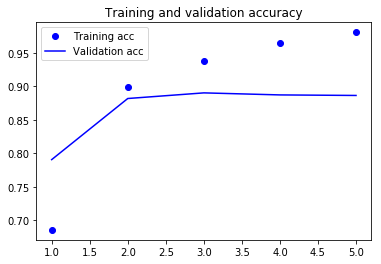

In [119]:
# Final evaluation of the model
scores = cnn_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# LSTM Recurrent Neural Network Model

In this part, we will work with Recurrent Neural Network to develop another model. Long Short Term Memory (LSTM) is used to improve the performace of RNN. One of the problems of RNN is that when the length of a text growing, even though it is designed to learn recurrently, it loses the ability to connect to information far away. In order to address the long-term dependency problem, so that the model can remember information for long period of time. 

The difference between LSTM and CNN model is that the Conv1D and MaxPooling layer are replaced by LSTM layer. In our case, we use 200 units as memory units and set dropout to address overfitting issue

The LSTM model is activated by Sigmoid as Sigmoid can output 0 or 1, it can help the model decide to store or forget certain information.

In [120]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
np.random.seed(7)
lstm_model = Sequential()
embedding_dim = 32
lstm_model.add(Embedding(max_words, embedding_dim, input_length = max_length))
# We use a LSTM layer
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
cnn_model.add(Dense(250, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.summary()
# Complie the model
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = lstm_model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=1, batch_size=64, verbose=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 400, 32)           320000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
Train on 12500 samples, validate on 12500 samples
Epoch 1/1


In [128]:
# Final evaluation of the model
scores = lstm_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.26%


# Example Application: Analyze Tweet Sentiment

In this part, we use the trained model to predict the sentiments of Donald Trump's twitter. First, we use Twitter API together with an library Tweepy to pull Trump's tweets. Then we preprocess the tweets by the same rules we process the training dataset.  

** The filter rule is designed for extracting contents from Trump's twitter account. If you try other's Twitter, the function may fail due to the format of tweet**

In [122]:
import tweepy
def getTweetsByName(query):
    consumer_key = 'bxA0fKeNXosrxAVnD9vEopblj'
    consumer_secret = 'gU55fTD7fxyrwxS9irs7DTzHALoKGqAbCwV8bhP8AY50vDpqLK'
    access_token = '4518122892-fn6CoLOGqMuD1b0IxNCqx5tbKIRJZTtRucoFeeM'
    access_token_secret = '2Osqvjqsn5Py8Yf773xVUv4jRsYIOvwn3SGyQTNFygG9w'
    
    auth = tweepy.OAuthHandler(consumer_key = consumer_key, 
                               consumer_secret = consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    api = tweepy.API(auth)
    tweets = api.user_timeline(screen_name=query)
    res = []
    for tweet in tweets:
        text = tweet.text.strip()
        # filter out tweets without text, which only contains video or link
        if text.startswith('https'):
            continue
        # remove "RT" (Retweet label)
        if text.startswith('RT @'):
            text = text[text.find(':') + 1:]
        # extract text from tweet, removing link
        idx = text.find('https')
        # if no link in this tweet
        if idx == -1:
            res.append(text)
        # otherwise remove link
        else:
            res.append(text[:idx])
    return res

Call the function to retrive tweets and preprocess to the tokenizer we trained before

In [123]:
# 
docs = getTweetsByName('realDonaldTrump')
processed_docs = t.texts_to_sequences(docs)
processed_docs = preprocessing.sequence.pad_sequences(processed_docs, maxlen=max_length, padding='post', truncating='post')

We use the trained model to predict the first 20 tweets from trump.

** One reason causing inaccuracy: **

One reason may lead to the inaccurate prediction is the length difference between training dataset and tweets. 

The averge length of movie reviews is 300, while that of tweet is 70. Due to the limited number of words, models may hard extract enough features to make prediction

In [124]:
# pd.options.display.max_colwidth = 100
# makeing predictions 
print (processed_docs.shape)
sentiments_cnn = cnn_model.predict(processed_docs)
# sentiments_rnn = lstm_model.predict(processed_docs)
# combine tweets and corresponding sentiment together
predict_df = pd.DataFrame(
    {'Score By CNN': sentiments_cnn.flatten(),
    'Tweet': docs
    })
print (predict_df)

(19, 400)
    Score By CNN                                                                                                Tweet
0       0.716297  Governor Jerry “Moonbeam” Brown pardoned 5 criminal illegal aliens whose crimes include (1) Kidn...
1       0.551064  ...does not include the Fake Washington Post, which is used as a “lobbyist” and should so  REGIS...
2       0.447002  While we are on the subject, it is reported that the U.S. Post Office will lose $1.50 on average...
3       0.749204  Washington spent trillions building up foreign countries while allowing OUR OWN infrastructure t...
4       0.627715  JOBS, JOBS, JOBS! Unemployment claims have fallen to a 45-year low. Together, we are making the ...
5       0.593934  We are going to REBUILD our crumbling infrastructure, and there is no better place to begin this...
6       0.515603  I have stated my concerns with Amazon long before the Election. Unlike others, they pay little o...
7       0.588390  ....In the interim, Hon. Rob

# Performance Compare with TextBlob and Future Work

In this part, we compare the performance between the model we trained using IMDB dataset and a third-party NLP library TextBlob. TextBlob allows the content as input and predict the sentiment is positive, negative or neutral. 

In [126]:
pd.options.display.max_colwidth = 50
from textblob import TextBlob
textbolb_res = []
for doc in docs:
    # predict using textblob
    analysis = TextBlob(doc)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        textbolb_res.append('positive')
    elif analysis.sentiment.polarity == 0:
        textbolb_res.append( 'neutral')
    else:
        textbolb_res.append ('negative')
predict_df['TextBlob_Result'] = pd.Series(textbolb_res)
print (predict_df)

    Score By CNN                                              Tweet TextBlob_Result
0       0.716297  Governor Jerry “Moonbeam” Brown pardoned 5 cri...        negative
1       0.551064  ...does not include the Fake Washington Post, ...        negative
2       0.447002  While we are on the subject, it is reported th...        negative
3       0.749204  Washington spent trillions building up foreign...        positive
4       0.627715  JOBS, JOBS, JOBS! Unemployment claims have fal...        positive
5       0.593934  We are going to REBUILD our crumbling infrastr...        negative
6       0.515603  I have stated my concerns with Amazon long bef...        negative
7       0.588390  ....In the interim, Hon. Robert Wilkie of DOD ...         neutral
8       0.601905  I am pleased to announce that I intend to nomi...        positive
9       0.639244  Great briefing this afternoon on the start of ...        positive
10      0.740487  ....release known dangerous criminals into com...        n

## Future Work
- In this tutorial, we train the embedding layer using the IMDB dataset. To improve accuracy, we can try to use some pre-trained word embeddings such as GloVe and word2vec
- We can use larger dataset with more epochs to improve  performance
- We can always add more hidden layers and tune the parameters to improve performance

# Reference
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/
- http://deeplearning.net/tutorial/lstm.html
- https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47
- http://ai.stanford.edu/~amaas/data/sentiment/